In [8]:
# # To avoid issues with multiple OpenMP libraries being loaded
# import os
# os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

#General Packages
import pandas as pd
import torch
import torch.nn.functional as F
import ast
import scipy.stats as stats


#Statistical tests
import statsmodels.formula.api as smf
from statsmodels.stats.multicomp import pairwise_tukeyhsd

#Plot
import seaborn as sns
import matplotlib.pyplot as plt

In [23]:
df = pd.read_csv("../pilot_study/generation_metadata.csv")
df

,model,attack,true_class,target_class,original_pred_class,adversarial_pred_class,first_success_iter,attack_successful,psnr_score,ssim_score,ergas_score,adversarial_image_path,original_probs,adversarial_probs,dataset_index
0,cifar10_resnet20,fgsm,0,1,0,1,6.0,True,79.583191,0.999987,4.428071e+00,results/adversarial_images/adv_fgsm_src0_tgt1_...,"[0.5656184554100037, 0.0004287524789106101, 0....","[0.0575563944876194, 0.5799181461334229, 0.002...",3
1,cifar10_resnet20,fgsm,0,1,0,0,19.0,False,79.908035,0.999988,1.491142e+06,results/adversarial_images/adv_fgsm_src0_tgt1_...,"[0.9999876022338867, 2.1175438291720639e-07, 1...","[0.8709576725959778, 0.07669635862112045, 0.00...",10
2,cifar10_resnet20,fgsm,0,1,0,0,NaN,False,79.219749,0.999987,1.485157e+00,results/adversarial_images/adv_fgsm_src0_tgt1_...,"[0.9998379945755005, 1.8206644369911373e-07, 0...","[0.3890906572341919, 0.026655003428459167, 0.2...",21
3,cifar10_resnet20,fgsm,0,1,0,0,40.0,False,79.402328,0.999986,1.258975e+01,results/adversarial_images/adv_fgsm_src0_tgt1_...,"[0.9999994039535522, 5.2288759988528e-09, 3.78...","[0.6505486965179443, 0.29666316509246826, 0.00...",27
4,cifar10_resnet20,fgsm,0,1,0,1,14.0,True,79.079018,0.999986,1.632679e+06,results/adversarial_images/adv_fgsm_src0_tgt1_...,"[1.0, 4.955166055253812e-09, 1.496597512584685...","[0.38779985904693604, 0.6119700074195862, 3.14...",44
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2695,cifar10_resnet20,cw,9,8,9,9,2.0,False,66.776321,0.999757,4.769467e+01,results/adversarial_images/adv_cw_src9_tgt8_id...,"[1.507966862845933e-05, 3.4976885217474774e-05...","[0.02198796160519123, 0.0003629106795415282, 0...",38
2696,cifar10_resnet20,cw,9,8,9,9,2.0,False,67.538155,0.999795,2.344464e+01,results/adversarial_images/adv_cw_src9_tgt8_id...,"[2.0656439403410332e-07, 2.5102206109295366e-0...","[2.2944954253034666e-05, 8.585227078583557e-06...",45
2697,cifar10_resnet20,cw,9,8,9,8,0.0,True,67.685326,0.999806,8.612302e+06,results/adversarial_images/adv_cw_src9_tgt8_id...,"[0.10539598762989044, 0.02581251971423626, 0.0...","[0.004368882160633802, 0.011918281204998493, 0...",47
2698,cifar10_resnet20,cw,9,8,9,8,2.0,True,67.275146,0.999784,9.410799e+06,results/adversarial_images/adv_cw_src9_tgt8_id...,"[3.3979356430791086e-06, 1.5708554201410152e-0...","[3.642470119302743e-06, 6.78123178659007e-05, ...",50


In [24]:
# Define and fit the model
model = smf.mixedlm("psnr_score ~ attack + C(target_class)", data=df, groups=df["dataset_index"]).fit()

# Print the summary
print(model.summary())


              Mixed Linear Model Regression Results
Model:               MixedLM    Dependent Variable:    psnr_score
No. Observations:    2700       Method:                REML      
No. Groups:          100        Scale:                 0.3331    
Min. group size:     27         Log-Likelihood:        -2450.3305
Max. group size:     27         Converged:             Yes       
Mean group size:     27.0                                        
-----------------------------------------------------------------
                     Coef.  Std.Err.    z     P>|z| [0.025 0.975]
-----------------------------------------------------------------
Intercept            67.057    0.045 1505.434 0.000 66.970 67.144
attack[T.fgsm]       12.458    0.027  457.920 0.000 12.405 12.511
attack[T.pgd]        14.310    0.027  525.972 0.000 14.256 14.363
C(target_class)[T.1] -0.361    0.050   -7.237 0.000 -0.459 -0.263
C(target_class)[T.2] -0.200    0.050   -4.015 0.000 -0.298 -0.103
C(target_class)[T.3]  0.

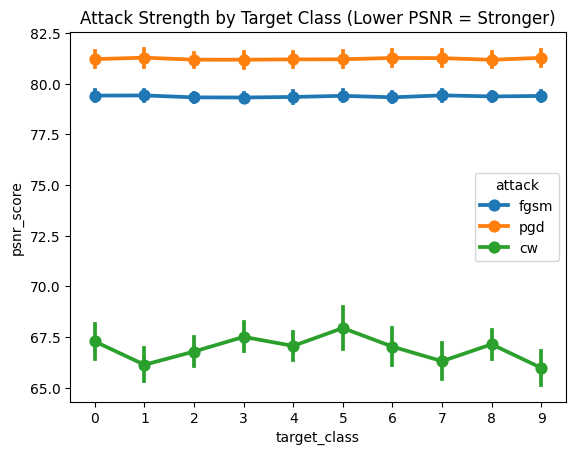

In [25]:
sns.pointplot(data=df, x='target_class', y='psnr_score', hue='attack', errorbar='sd')
plt.title("Attack Strength by Target Class (Lower PSNR = Stronger)")
plt.show()

### KL divergence in probability distribution

In [39]:
df["original_probs"] = df["original_probs"].apply(ast.literal_eval)
df["adversarial_probs"] = df["adversarial_probs"].apply(ast.literal_eval)

C:\Users\canic\AppData\Local\Temp\ipykernel_23544\4037593332.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["original_probs"] = df["original_probs"].apply(ast.literal_eval)
C:\Users\canic\AppData\Local\Temp\ipykernel_23544\4037593332.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["adversarial_probs"] = df["adversarial_probs"].apply(ast.literal_eval)


In [40]:
def kl_divergence(p, q):
    # Convert to tensors
    p = torch.tensor(p, dtype=torch.float32)
    q = torch.tensor(q, dtype=torch.float32)

    # Add small epsilon to avoid log(0)
    epsilon = 1e-8
    p = p + epsilon
    q = q + epsilon

    return F.kl_div(q.log(), p, reduction="sum").item()  

In [41]:
df["kl_divergence"] = df.apply(lambda row: kl_divergence(row["original_probs"], row["adversarial_probs"]), axis=1)


C:\Users\canic\AppData\Local\Temp\ipykernel_23544\3706757358.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["kl_divergence"] = df.apply(lambda row: kl_divergence(row["original_probs"], row["adversarial_probs"]), axis=1)


In [42]:
print(df.groupby("attack")["kl_divergence"].mean())

attack
cw       0.436833
fgsm    17.802873
pgd      9.864644
Name: kl_divergence, dtype: float64


In [43]:
print(df[["kl_divergence", "psnr_score"]].corr())

               kl_divergence  psnr_score
kl_divergence       1.000000   -0.472713
psnr_score         -0.472713    1.000000


In [44]:
model = smf.mixedlm("kl_divergence ~ attack", data=df, groups=df["dataset_index"])
result = model.fit()

print(result.summary())

           Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: kl_divergence
No. Observations: 1230    Method:             REML         
No. Groups:       50      Scale:              11.3649      
Min. group size:  18      Log-Likelihood:     -3273.3101   
Max. group size:  27      Converged:          Yes          
Mean group size:  24.6                                     
-----------------------------------------------------------
                 Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------
Intercept         0.442    0.227  1.950 0.051 -0.002  0.886
attack[T.fgsm]   17.361    0.227 76.527 0.000 16.916 17.806
attack[T.pgd]     9.268    0.245 37.780 0.000  8.788  9.749
Group Var         1.258    0.105                           



# Succesrate

In [45]:
# Create contingency table: rows = attack type, columns = success (True/False)
contingency = pd.crosstab(df['attack'], df['attack_successful'])

print("Contingency Table:\n", contingency)

# Chi-squared test
chi2, p, dof, expected = stats.chi2_contingency(contingency)

print("\nChi-squared Test Results:")
print(f"Chi2 Statistic: {chi2:.4f}")
print(f"Degrees of Freedom: {dof}")
print(f"P-value: {p:.4e}")
print("\nExpected Frequencies:\n", pd.DataFrame(expected, index=contingency.index, columns=contingency.columns))


Contingency Table:
 attack_successful  True
attack                 
cw                  434
fgsm                450
pgd                 346

Chi-squared Test Results:
Chi2 Statistic: 0.0000
Degrees of Freedom: 0
P-value: 1.0000e+00

Expected Frequencies:
 attack_successful   True
attack                  
cw                 434.0
fgsm               450.0
pgd                346.0
